# Classification de champignons ou Puis-je manger ce champignon qui me paraît très attirant sans risquer de provoquer une nouvelle pandémie mondiale 
Raphaël Bourgeois - INSA Toulouse

# Librairies

In [367]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

class OneHotEncoder(SklearnOneHotEncoder): # classe heritant de onehotencoder afin d'avoir le nom des colonnes + de la modalités,  https://towardsdatascience.com/how-to-assign-labels-with-sklearn-one-hot-encoder-e59a5f17df4f
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns

In [386]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , learning_curve
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# 1 - Les données

## 1.1 - Aperçu

In [369]:
#Lecture des données 
df = pd.read_csv('train.csv')

df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,7006,7006,7006,7006,7006,7006,7006,7006,7006,7006,...,7006,7006,7006,7006,7006,7006,7006,7006,7006,7006
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,3634,3125,2808,1965,4105,3056,6819,5864,4856,1477,...,4250,3839,3755,7006,6832,6457,3412,2046,3486,2718


On a 7006 individus et 22 attributs + 1 attributs cible *class*, nous allons donc realiser un modèle qui permet de faire de la classification supervisée. On remarque egalement que les attributs de predictions sont des variables qualitatives sans relation d'ordre apparentes. On pourra discuter de cette absence de relation d'ordre pour certains attributs ( exemple : *ring-number* , est-ce qu'il faut accorder plus de poids à un champignon avec deux rings qu'un champignon avec zero ring ) 

In [370]:
# Découpage du dataframe en données d'entrainement et de test 
train , test = train_test_split (df, test_size = 0.2 , random_state = 0)
print (train['class'].value_counts() )
print ( test['class'].value_counts() )

e    2909
p    2695
Name: class, dtype: int64
e    725
p    677
Name: class, dtype: int64


La repartition des champignons comestibles ou non dans le trainset et le testset est satifaisant

## 1.2 - Re-structuration des données ( pre-processing )

Nous allons desormais restructurer le dataframe d'entrainement

In [371]:
# Valeurs manquantes dans la colone stalk-root
train["stalk-root"] = train["stalk-root"].replace("?","NaN")
missing_rate = train["stalk-root"].value_counts().NaN / train["stalk-root"].count()
print(missing_rate)
train[["stalk-root","class"]].groupby("stalk-root").describe()

0.30960028551034974


class                 
           count unique top  freq
stalk-root                       
NaN         1735      2   p  1212
b           2632      2   e  1349
c            368      2   e   336
e            745      2   e   577
r            124      1   e   124

La proportion de valeurs manquantes dans la colonne *stalk-root* est d'environ 30%. Supprimer tout les individus ayant une valeurs manquante provoquera une chute de 30% de l'effectif, le sous-effectif resultant pouvant ne pas être un echantillon representatif. On peut donc choisir de ne plus considerer la colonne *stalk-root* en la supprimant mais on accepted de prendre le risque de perdre une variable ayant un forte influence sur les predcition de notre modele. En effet, dans le tableau ci-dessus, on remarque par exemple que tout les champignons *r = rooted* sont comestibles, c'est peut-être un facteur très important dans la determination de la comestibilité. Un autre solution est de faire de l'imputation afin de remplacer les valeurs manquantes par une des modalités selon une certaine règle, on peut choisir de repartir afin que la fréquence d'apparition des attributs ne soit pas modifié. La limite de cette solution est qu'on ferai une hypothèse sur le caratère aléatoire du *stalk-root* d'un champignons. En effet, si le fait d'avoir tel ou tel *stalk-root* est influencé ou influence d'autre caracteristiques, une meilleure solution aurait été de faire de l'imputation en utilisant un modele de prediction sur la variable manquante (par exemple un kNN).

Afin de simplifier la suite de l'étude, on prend la décision de supprimer la colonne *stalk-root*

In [372]:
train = train.drop(columns=["stalk-root"])
train.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3149,p,x,f,y,f,f,f,c,b,p,...,k,p,p,p,w,o,l,h,v,g
4639,e,x,f,n,t,n,f,c,b,u,...,s,w,w,p,w,o,p,n,v,d
4111,p,x,s,n,f,s,f,c,n,b,...,s,p,p,p,w,o,e,w,v,p
3509,p,f,y,y,f,f,f,c,b,g,...,k,b,n,p,w,o,l,h,y,g
223,p,f,y,e,f,f,f,c,n,b,...,s,w,w,p,w,o,e,w,v,l


In [373]:
# Encodage des variables qualitatives ( on fit l'encoder avec le df afin qu'il prenne en compte toute les modalités)
df_to_enc = df.drop(columns=["stalk-root"]) 
enc = OneHotEncoder()
enc.fit(df_to_enc)

train_enc = enc.transform(train)

train_enc

,class_<e>,class_<p>,cap-shape_<b>,cap-shape_<c>,cap-shape_<f>,cap-shape_<k>,cap-shape_<s>,cap-shape_<x>,cap-surface_<f>,cap-surface_<g>,...,population_<s>,population_<v>,population_<y>,habitat_<d>,habitat_<g>,habitat_<l>,habitat_<m>,habitat_<p>,habitat_<u>,habitat_<w>
3149,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4639,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3509,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
223,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1653,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2607,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [374]:
def preprocess(df , encoder ):
    df = df.drop(columns=["stalk-root"]) #suppression de la colonne stalk-root
    df_enc = encoder.transform(df)
    X = df_enc.drop(columns=["class_<e>","class_<p>"]) # données d'entrée du modèle 
    y = df_enc.iloc[:,0] # données cible du modèle
    return X , y

In [375]:
train , test = train_test_split (df, test_size = 0.2 , random_state = 0)

X_test , y_test = preprocess(test,enc)
X_train , y_train = preprocess(train,enc)
y_train

3149    0.0
4639    1.0
4111    0.0
3509    0.0
223     0.0
       ... 
4931    0.0
3264    1.0
1653    1.0
2607    0.0
2732    1.0
Name: class_<e>, Length: 5604, dtype: float64

# 2 - Le modèle

On commence avec un modèle simple : un arbre de décision

In [376]:
model = DecisionTreeClassifier (random_state=0)

In [377]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print ( all(y_test.values == y_pred ))
print(y_train.value_counts())

True
1.0    2909
0.0    2695
Name: class_<e>, dtype: int64


Comme le montre le test ci-dessus, on remarque que notre arbre de décision a très facilement appris les données et que les prediction qu'il a réalisé sur les données de test sont bonnes à 100 %. Ne nous enflammons pas, nous somme surement en situation de sur-apprentissage. Cepandant, nous pouvons quand même exploiter ce modèle afin d'en tirer certaines information sur nos données. Affichons une representation graphique de l'abre de decision :

[Text(153.45000000000002, 203.85, 'odor_<n> <= 0.5\ngini = 0.499\nsamples = 5604\nvalue = [2695, 2909]\nclass = e'),
 Text(55.800000000000004, 176.67000000000002, 'bruises_<t> <= 0.5\ngini = 0.278\nsamples = 3142\nvalue = [2617, 525]\nclass = p'),
 Text(27.900000000000002, 149.49, 'gini = 0.0\nsamples = 2250\nvalue = [2250, 0]\nclass = p'),
 Text(83.7, 149.49, 'spore-print-color_<h> <= 0.5\ngini = 0.484\nsamples = 892\nvalue = [367, 525]\nclass = e'),
 Text(55.800000000000004, 122.31, 'odor_<p> <= 0.5\ngini = 0.367\nsamples = 693\nvalue = [168, 525]\nclass = e'),
 Text(27.900000000000002, 95.13, 'gini = 0.0\nsamples = 525\nvalue = [0, 525]\nclass = e'),
 Text(83.7, 95.13, 'gini = 0.0\nsamples = 168\nvalue = [168, 0]\nclass = p'),
 Text(111.60000000000001, 122.31, 'gini = 0.0\nsamples = 199\nvalue = [199, 0]\nclass = p'),
 Text(251.10000000000002, 176.67000000000002, 'spore-print-color_<r> <= 0.5\ngini = 0.061\nsamples = 2462\nvalue = [78, 2384]\nclass = e'),
 Text(223.20000000000002, 1

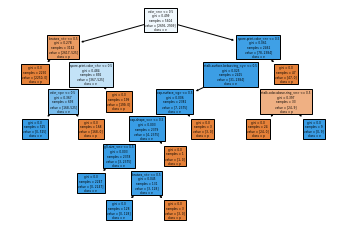

In [366]:
plot_tree(model, feature_names=X_test.columns, filled=True , class_names= ['p','e'])

Les feuilles bleues de l'arbre representent la classe *e* , et les feuilles orange la classe *p*. Du fait du choix d'encoder les variables en one-hot, cette representation graphique nous montre les modalités importantes que l'arbre de décision utilise pour classifier les champignons. Par exemple, on remarque sur la décision prise sur la racine de l'arbre porte sur le fait que le champignons soit odorant ou pas. La branche de droite de la racine (donc la branche des champignons odorants) comporte 2384 champignons comestibles et 78 champignons non-comestibles. La branche de gauche quant à elle comporte 2617 champignons non-comestibles et 525 champignons comestibles. Cette arbre de décision nous apprend donc que sur nos données d'entrainement, le caractère odorant d'un champignons est déja un caractère determinant sur sa comestibilité.

On peut afficher l'importance que le modele apporte à chaque variables :

In [384]:
#importance des variables
pd.set_option("display.max_rows", None, "display.max_columns", None) #modification des options de pandas afin d'avoir un affichage complet 
VarImp = { "Variable" : X_train.columns , "Importance": model.feature_importances_}
print(pd.DataFrame(VarImp).sort_values(by= "Importance" ,ascending=False))

                         Variable  Importance
27                       odor_<n>    0.633437
21                    bruises_<t>    0.160266
28                       odor_<p>    0.090977
91          spore-print-color_<h>    0.063426
95          spore-print-color_<r>    0.032114
58   stalk-surface-below-ring_<y>    0.012207
63     stalk-color-above-ring_<n>    0.004679
7                 cap-surface_<g>    0.002135
1                   cap-shape_<c>    0.000713
36                  gill-size_<n>    0.000046
80                 veil-color_<w>    0.000000
79                 veil-color_<o>    0.000000
78                 veil-color_<n>    0.000000
77                  veil-type_<p>    0.000000
81                 veil-color_<y>    0.000000
76     stalk-color-below-ring_<y>    0.000000
75     stalk-color-below-ring_<w>    0.000000
73     stalk-color-below-ring_<o>    0.000000
74     stalk-color-below-ring_<p>    0.000000
83                ring-number_<o>    0.000000
72     stalk-color-below-ring_<n> 

Voici donc la liste des variables <modalité> importantes pour le modele :

odor_<n>    bruises_<t>    odor_<p>    spore-print-color_<h>    spore-print-color_<r>    stalk-surface-below-ring_<y>    stalk-color-above-ring_<n>   cap-surface_<g> cap-shape_<c>   

Cela nous donne envie de refaire une étape de preprocessing en selectionnant uniquement ces colonnes

# 3 - Qualité du modèle

Pour evaluer la qualité du modèle, on va se servir de la metrique F1, cela nour permettra d'avoir le taux de faux positif et de faux negatif du modèle

In [278]:
# fonction d'evaluation du modèle

def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [279]:
evaluation(model)

[[725   0]
 [  0 677]]
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       725
           p       1.00      1.00      1.00       677

    accuracy                           1.00      1402
   macro avg       1.00      1.00      1.00      1402
weighted avg       1.00      1.00      1.00      1402



# 4 - Identification des variables pertinentes 